In [1]:
!kaggle competitions download -c bhw-1-dl-2023-2024

"kaggle" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [3]:
!unzip bhw-1-dl-2023-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: bhw1/trainval/trainval_95000.jpg  
  inflating: bhw1/trainval/trainval_95001.jpg  
  inflating: bhw1/trainval/trainval_95002.jpg  
  inflating: bhw1/trainval/trainval_95003.jpg  
  inflating: bhw1/trainval/trainval_95004.jpg  
  inflating: bhw1/trainval/trainval_95005.jpg  
  inflating: bhw1/trainval/trainval_95006.jpg  
  inflating: bhw1/trainval/trainval_95007.jpg  
  inflating: bhw1/trainval/trainval_95008.jpg  
  inflating: bhw1/trainval/trainval_95009.jpg  
  inflating: bhw1/trainval/trainval_95010.jpg  
  inflating: bhw1/trainval/trainval_95011.jpg  
  inflating: bhw1/trainval/trainval_95012.jpg  
  inflating: bhw1/trainval/trainval_95013.jpg  
  inflating: bhw1/trainval/trainval_95014.jpg  
  inflating: bhw1/trainval/trainval_95015.jpg  
  inflating: bhw1/trainval/trainval_95016.jpg  
  inflating: bhw1/trainval/trainval_95017.jpg  
  inflating: bhw1/trainval/trainval_95018.jpg  
  inflating: bhw1/trainval/trainval_9

In [5]:
import torch
from torch import nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torchvision.transforms import v2
import seaborn as sns
import os

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
labels_df = pd.read_csv("bhw1/labels.csv")
labels_df

,Id,Category
0,trainval_00000.jpg,7
1,trainval_00001.jpg,198
2,trainval_00002.jpg,161
3,trainval_00003.jpg,131
4,trainval_00004.jpg,107
...,...,...
99995,trainval_99995.jpg,72
99996,trainval_99996.jpg,194
99997,trainval_99997.jpg,6
99998,trainval_99998.jpg,29


In [9]:
n_classes = len(labels_df.Category.unique())
n_classes

200

In [10]:
# посмотрим, что всё подгружается
img = torchvision.io.read_image("bhw1/trainval/trainval_00001.jpg")
img

tensor([[[ 24,  30,  40,  ...,  37,  36,  24],
         [ 40,  44,  53,  ...,  61,  70,  40],
         [ 44,  51,  60,  ...,  55,  63,  42],
         ...,
         [ 37,  65,  92,  ..., 119, 109,  89],
         [ 62,  91, 117,  ..., 119, 109,  91],
         [ 46,  65,  83,  ...,  91,  79,  60]],

        [[ 26,  27,  31,  ...,  15,  19,   9],
         [ 38,  39,  41,  ...,  40,  52,  23],
         [ 38,  41,  44,  ...,  32,  42,  25],
         ...,
         [ 21,  46,  71,  ...,  79,  74,  58],
         [ 44,  72,  93,  ...,  83,  78,  61],
         [ 27,  46,  57,  ...,  56,  49,  32]],

        [[  0,   0,   0,  ...,   2,  12,   6],
         [  0,   0,   1,  ...,  21,  40,  15],
         [  4,   6,  10,  ...,   1,  21,   7],
         ...,
         [  8,  29,  42,  ...,  18,  18,   3],
         [ 34,  57,  65,  ...,  25,  24,  11],
         [ 20,  31,  32,  ...,   0,   0,   0]]], dtype=torch.uint8)

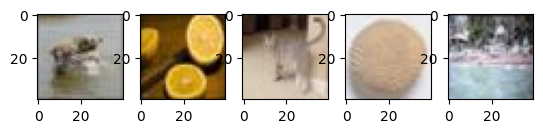

In [11]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    img = torchvision.io.read_image(f"bhw1/trainval/trainval_0000{i}.jpg")
    axs[i].imshow(torch.moveaxis(img, 0, 2))
plt.show()

In [12]:
# реализуем датасет 

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file: str, root_dir: str, transform):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.labels_frame.Id = self.root_dir + self.labels_frame.Id
        self.transform = transform
        self.imgs = (
            self.labels_frame.iloc[:, 0]
            .apply(torchvision.io.read_image)
            .apply(self.transform)
            .to_numpy()
        )

    def __len__(self) -> int:
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        class_num = self.labels_frame.iloc[idx, 1]
        sample = (self.imgs[idx], class_num)

        return sample

In [13]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [14]:
dataset = ImageDataset("bhw1/labels.csv", "bhw1/trainval/", transform)
dataset[0][0]

tensor([[[ 0.4337,  0.7762,  0.8961,  ..., -0.6965, -0.7137, -1.0048],
         [ 0.5193,  0.8789,  0.9817,  ..., -0.3541, -0.3883, -0.6452],
         [ 0.4679,  0.8276,  0.9474,  ...,  0.0569,  0.0056, -0.2342],
         ...,
         [ 0.1768,  0.5193,  0.6221,  ...,  0.4337,  0.5193,  0.0569],
         [ 0.0912,  0.4337,  0.5364,  ...,  0.5022,  0.5878,  0.1254],
         [-0.1828,  0.1597,  0.2453,  ...,  0.0227,  0.0912, -0.3712]],

        [[ 0.5903,  0.9405,  1.0630,  ..., -0.6877, -0.7227, -1.0203],
         [ 0.6779,  1.0455,  1.1506,  ..., -0.3550, -0.3550, -0.6527],
         [ 0.6254,  0.9930,  1.1155,  ...,  0.0826,  0.0826, -0.2150],
         ...,
         [ 0.2927,  0.6429,  0.7479,  ...,  0.5903,  0.6604,  0.1877],
         [ 0.2052,  0.5553,  0.6604,  ...,  0.6254,  0.7129,  0.2402],
         [-0.0749,  0.2752,  0.3627,  ...,  0.1352,  0.2052, -0.2675]],

        [[ 0.8448,  1.1934,  1.3154,  ..., -0.8458, -0.8284, -1.1247],
         [ 0.9319,  1.2980,  1.4025,  ..., -0

In [15]:
len(dataset)

100000

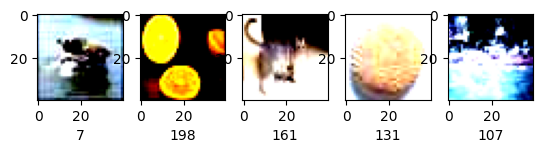

In [16]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    img = dataset[i][0]
    axs[i].imshow(torch.moveaxis(img, 0, 2))
    axs[i].set_xlabel(dataset[i][1])
plt.show()

In [17]:
# создадим базовый блок нашей сети (будем делать что-то похожее на resnet):

class BasicBlockNet(nn.Module):
    def __init__(self, n_in_channels, n_out_channels, stride=1):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=n_in_channels,
                out_channels=n_out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(n_out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=n_out_channels,
                out_channels=n_out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(n_out_channels),
            nn.ReLU(),
        )

        self.conv = nn.Conv2d(
            in_channels=n_in_channels, out_channels=n_out_channels, kernel_size=1
        )

    def forward(self, x):
        out = nn.ReLU()(self.block(x) + self.conv(x))

        return out

In [18]:
# создадим сеть


class MyWRN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=256,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            BasicBlockNet(
                n_in_channels=256,
                n_out_channels=256,
            ),
            BasicBlockNet(
                n_in_channels=256,
                n_out_channels=512,
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlockNet(
                n_in_channels=512,
                n_out_channels=1024,
            ),
            nn.AvgPool2d(kernel_size=2, stride=2),
            BasicBlockNet(
                n_in_channels=1024,
                n_out_channels=2048,
            ),
            nn.AvgPool2d(kernel_size=5, stride=5),
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=2048, out_features=200),
            nn.Dropout(0.5),
          )

    def forward(self, x):
        out = self.linear(torch.flatten(self.net(x), start_dim=1))

        return out

In [19]:
net = MyWRN()
net

MyWRN(
  (net): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): BasicBlockNet(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): BasicBlockNet(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [20]:
assert net(torch.zeros((10, 3, 40, 40))).shape == (10, 200)

In [21]:
net = net.to(device)

In [22]:
def plot_metrics(metric_train, metric_val, name="loss"):
    norm_metric_val = {}

    batch_num = len(metric_train) // len(metric_val)

    for i in range(len(metric_val)):
        norm_metric_val[(i + 1) * batch_num] = metric_val[i]
    data = {"train": metric_train, "val": norm_metric_val}
    ax = sns.relplot(data=data, kind="line")
    ax.set(xlabel="step", ylabel=name)
    plt.show()

In [23]:
from torch.nn.functional import cross_entropy

def predict(model, loader):
    predictions = []
    model.eval()

    with torch.no_grad():

        for data in loader:
            data = data.to(device)
            predictions += [torch.argmax(model(data), 1).cpu().item()]

    return predictions


def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)

            predictions = model(data)
            loss = cross_entropy(predictions, target)

            loss_log.append(loss.item())

            predicted_classes = torch.argmax(predictions, 1)
            acc = torch.sum(predicted_classes == target) / target.size(dim=0)

            acc_log.append(acc.item())


    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        loss = cross_entropy(predictions, target)

        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()

        predicted_classes = torch.argmax(predictions, 1)
        acc = torch.sum(predicted_classes == target) / target.size(dim=0)
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        plot_metrics(train_acc_log, val_acc_log, name="acc")
        if epoch % 5 == 4:
            torch.save(model.state_dict(), f"./models/my_res_net_epoch_{epoch + 1}")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [24]:
def train_test_split_indices(n, test_ratio=0.2, random_state=57):
    np.random.seed(random_state)
    train_indices = np.random.choice(
        n,
        size=int(n * (1 - test_ratio)),
        replace=False,
    )
    test_indices = np.delete(np.arange(0, n), train_indices)
    return (
        train_indices,
        test_indices,
    )

In [25]:
train_indices, test_indices = train_test_split_indices(len(dataset), test_ratio=0.01)

In [26]:
final_transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [27]:
val_dataset = ImageDataset("bhw1/labels.csv", "bhw1/trainval/", transform=final_transform)
val_dataset[range(5)][0]

array([tensor([[[-1.0048, -0.7137, -0.6965,  ...,  0.8961,  0.7762,  0.4337],
                [-0.6452, -0.3883, -0.3541,  ...,  0.9817,  0.8789,  0.5193],
                [-0.2342,  0.0056,  0.0569,  ...,  0.9474,  0.8276,  0.4679],
                ...,
                [ 0.0569,  0.5193,  0.4337,  ...,  0.6221,  0.5193,  0.1768],
                [ 0.1254,  0.5878,  0.5022,  ...,  0.5364,  0.4337,  0.0912],
                [-0.3712,  0.0912,  0.0227,  ...,  0.2453,  0.1597, -0.1828]],

               [[-1.0203, -0.7227, -0.6877,  ...,  1.0630,  0.9405,  0.5903],
                [-0.6527, -0.3550, -0.3550,  ...,  1.1506,  1.0455,  0.6779],
                [-0.2150,  0.0826,  0.0826,  ...,  1.1155,  0.9930,  0.6254],
                ...,
                [ 0.1877,  0.6604,  0.5903,  ...,  0.7479,  0.6429,  0.2927],
                [ 0.2402,  0.7129,  0.6254,  ...,  0.6604,  0.5553,  0.2052],
                [-0.2675,  0.2052,  0.1352,  ...,  0.3627,  0.2752, -0.0749]],

               [[-

In [28]:
trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(val_dataset, test_indices)

In [29]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=0, pin_memory=True)

In [30]:
!mkdir models

In [31]:
from torchvision.models.resnet import _resnet, BasicBlock, Bottleneck, resnet18, resnet34, resnet50, resnet101, wide_resnet50_2, wide_resnet101_2
from torchvision.models.efficientnet import _efficientnet_conf, _efficientnet
from torchvision.models import efficientnet_v2_s, efficientnet_b0
from torch.optim.lr_scheduler import ExponentialLR

Epoch 0
 train loss: 5.1894349608310435, train acc: 0.02008640180878553
 val loss: 4.926279067993164, val acc: 0.0321514424867928



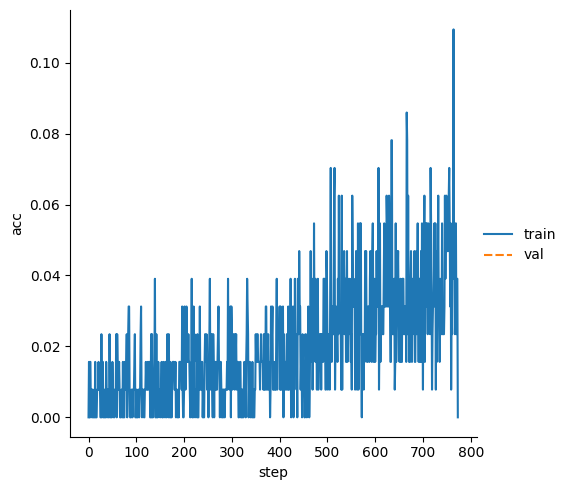

Epoch 1
 train loss: 4.923869464440555, train acc: 0.05548634182767659
 val loss: 4.569203615188599, val acc: 0.0975811299867928



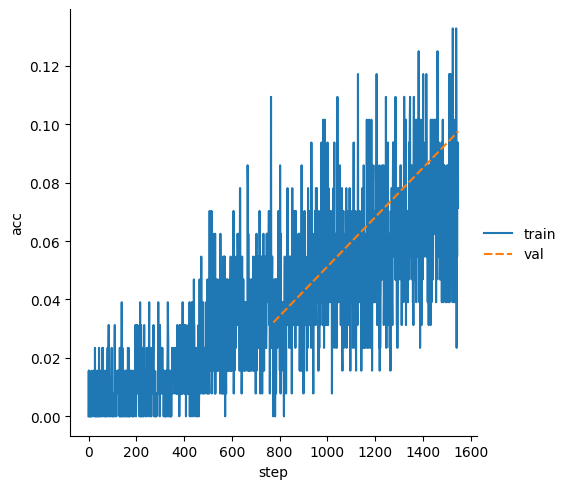

Epoch 2
 train loss: 4.660782936623546, train acc: 0.09963605113000217
 val loss: 4.274309515953064, val acc: 0.1365685099735856



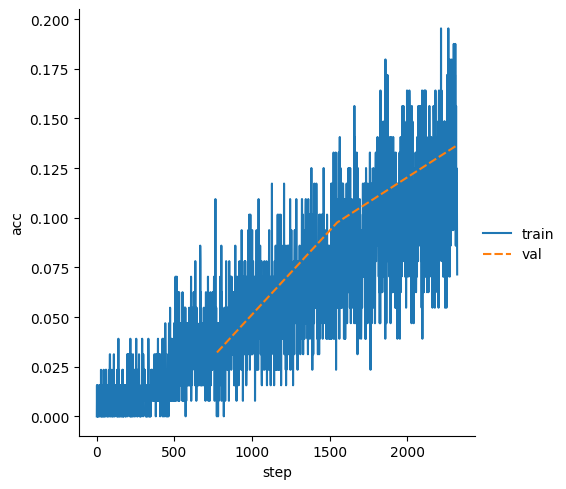

Epoch 3
 train loss: 4.43929654005578, train acc: 0.14124936554629058
 val loss: 3.9042129814624786, val acc: 0.21108774095773697



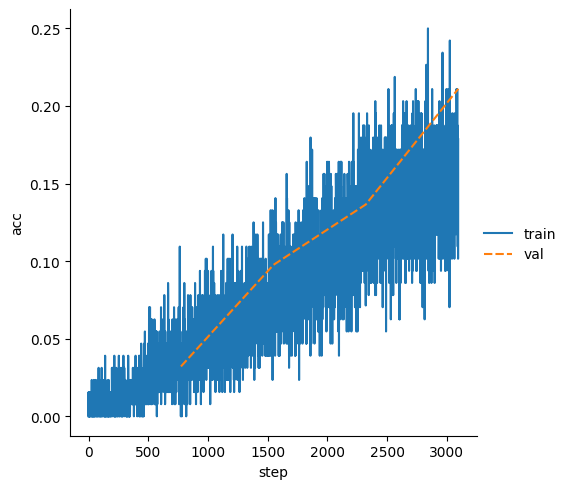

Epoch 4
 train loss: 4.283844697999092, train acc: 0.16986491787187197
 val loss: 3.6581479609012604, val acc: 0.23737980797886848



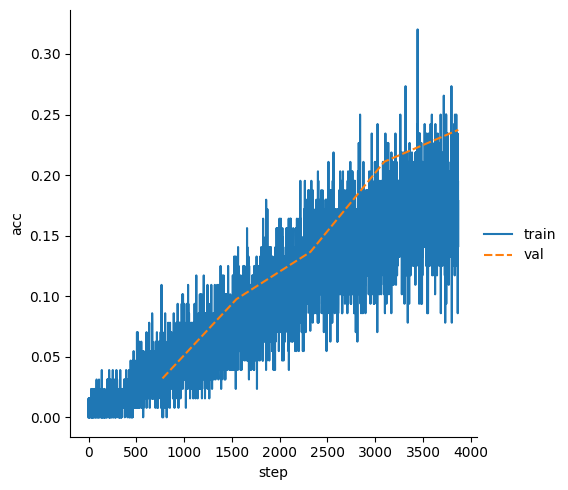

Epoch 5
 train loss: 4.147759553998015, train acc: 0.1951293720062389
 val loss: 3.490697503089905, val acc: 0.2958233170211315



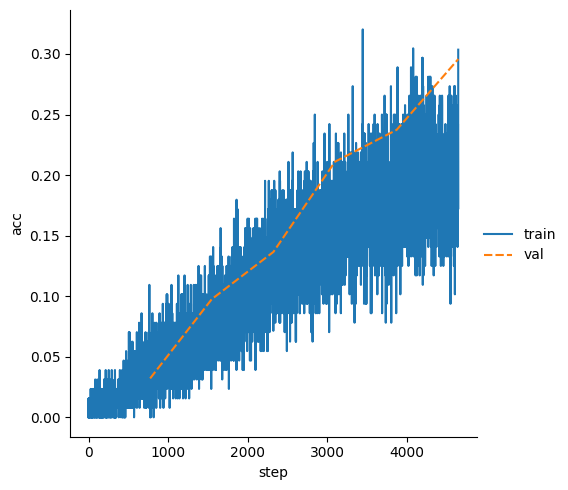

Epoch 6
 train loss: 4.022639575238684, train acc: 0.21867501847349705
 val loss: 3.3828082978725433, val acc: 0.33082932978868484



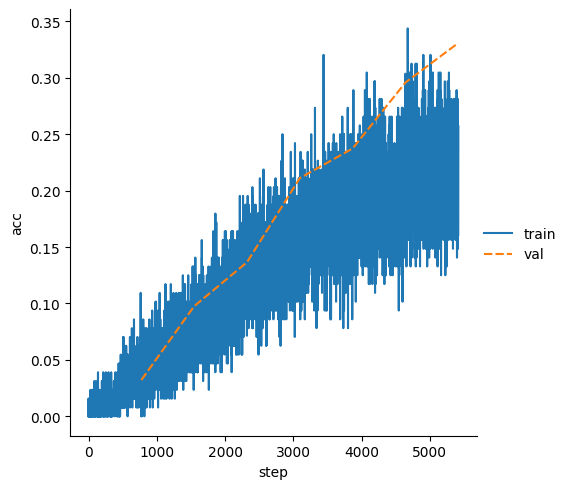

Epoch 7
 train loss: 3.8987793121535033, train acc: 0.24407213225537183
 val loss: 3.1761757731437683, val acc: 0.33578726276755333



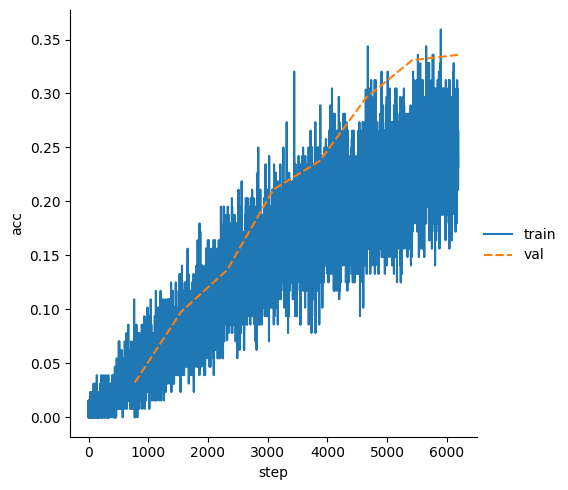

Epoch 8
 train loss: 3.7770985460404587, train acc: 0.26709290790234425
 val loss: 3.096082717180252, val acc: 0.3740234375



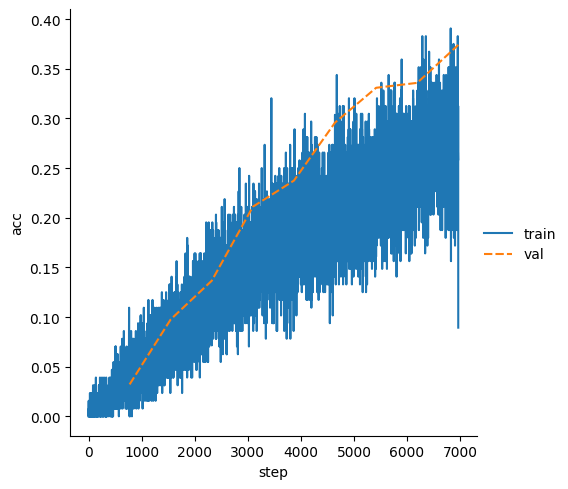

Epoch 9
 train loss: 3.65676916754523, train acc: 0.29140711519915313
 val loss: 3.014933615922928, val acc: 0.34990985691547394



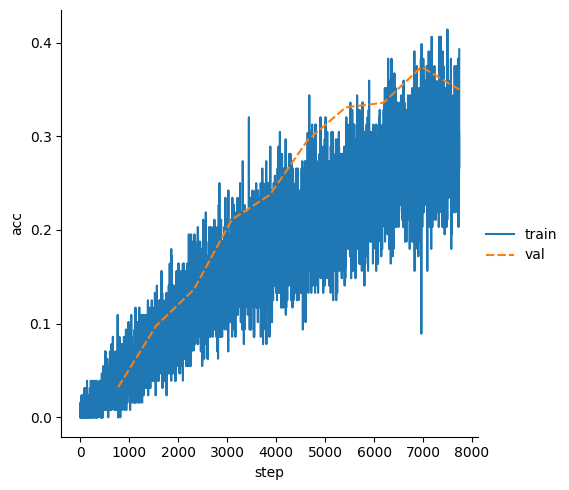

Epoch 10
 train loss: 3.507433257053681, train acc: 0.3220039105923601
 val loss: 2.915302664041519, val acc: 0.3701171875



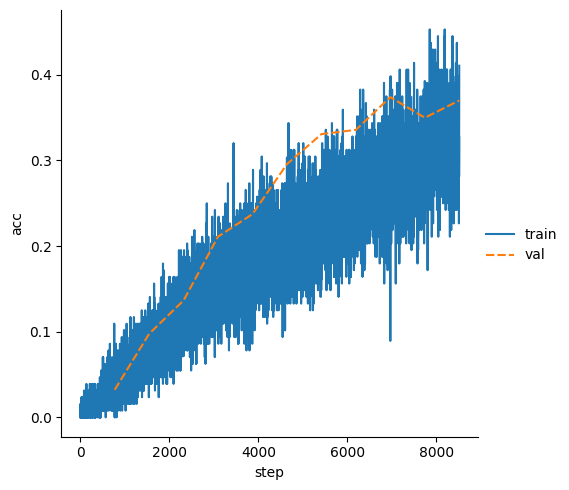

Epoch 11
 train loss: 3.3705904437590015, train acc: 0.34651278148017806
 val loss: 2.799791246652603, val acc: 0.39190204441547394



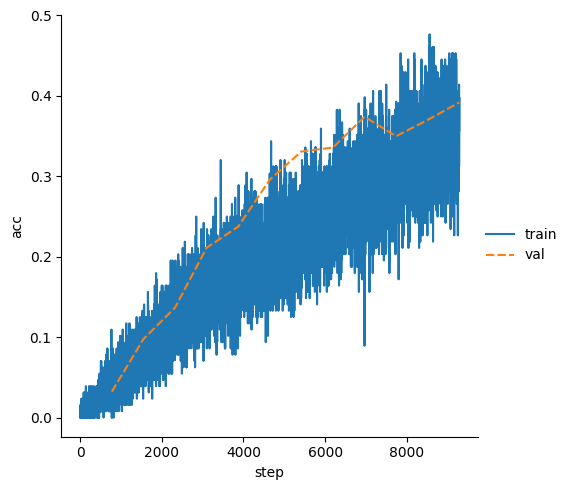

Epoch 12
 train loss: 3.2064300695439027, train acc: 0.38096680051288556
 val loss: 2.696620672941208, val acc: 0.42210036143660545



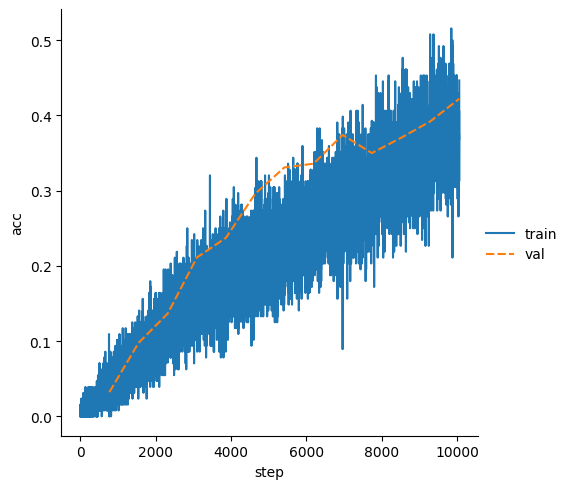

Epoch 13
 train loss: 3.0393005276835243, train acc: 0.4116443452600977
 val loss: 2.7013957798480988, val acc: 0.3979867808520794



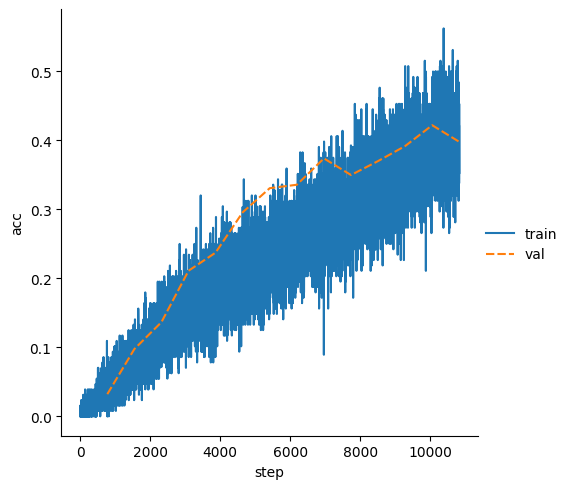

Epoch 14
 train loss: 2.895408707687713, train acc: 0.43774657394226824
 val loss: 2.6747359931468964, val acc: 0.41233473643660545



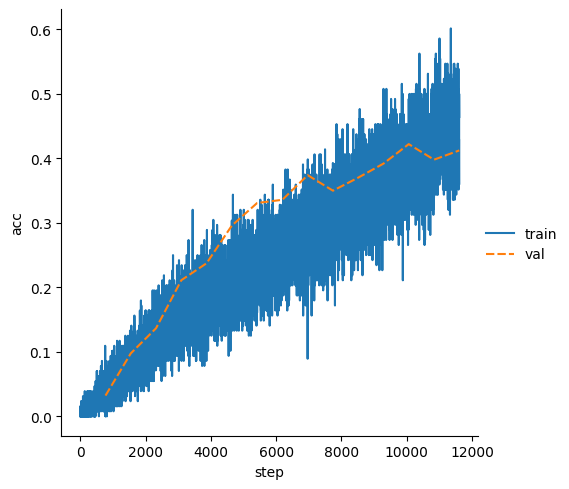

KeyboardInterrupt: 

In [32]:
net = MyWRN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.99)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 15, train_loader, val_loader, scheduler
)

In [ ]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: str, transform):

        self.root_dir = root_dir
        self.labels_frame = pd.DataFrame(os.listdir(root_dir))
        self.labels_frame[0] = root_dir + self.labels_frame[0]
        self.transform = transform
        self.imgs = (
            self.labels_frame.iloc[:, 0]
            .apply(torchvision.io.read_image)
            .apply(self.transform)
            .to_numpy()
        )

    def __len__(self) -> int:
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.imgs[idx]

        return sample

In [ ]:
test_dataset = TestImageDataset(root_dir="bhw1/test/", transform=final_transform)
test_dataset[range(5)][0]

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, num_workers=0)

predictions = predict(net, test_loader)
predictions[:2]

In [ ]:
test_imgs = os.listdir("bhw1/test/")
res_df = pd.DataFrame(zip(test_imgs, predictions))
res_df.rename(columns={0: "Id", 1: "Category"}, inplace=True)
res_df.set_index("Id", inplace=True)
res_df.to_csv("labels_test.csv")